## Song Popularity Prediction for Spotify Dataset

### Importing Libraries

In [1]:
import os

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

from sklearn import datasets
from sklearn.compose import ColumnTransformer, make_column_transformer
from sklearn.dummy import DummyRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.impute import SimpleImputer
from sklearn.linear_model import Ridge

from sklearn.model_selection import (
    cross_val_score,
    cross_validate,
    train_test_split,
)

from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.preprocessing import OneHotEncoder, OrdinalEncoder, StandardScaler
from sklearn.tree import DecisionTreeRegressor, export_graphviz

%matplotlib inline

### Data Preprocessing

In [2]:
spotify_df = pd.read_csv("SpotifyFeatures.csv")
spotify_df.head()

,genre,artist_name,track_name,track_id,popularity,acousticness,danceability,duration_ms,energy,instrumentalness,key,liveness,loudness,mode,speechiness,tempo,time_signature,valence
0,Movie,Henri Salvador,C'est beau de faire un Show,0BRjO6ga9RKCKjfDqeFgWV,0,0.611,0.389,99373,0.910,0.000,C#,0.3460,-1.828,Major,0.0525,166.969,4/4,0.814
1,Movie,Martin & les fées,Perdu d'avance (par Gad Elmaleh),0BjC1NfoEOOusryehmNudP,1,0.246,0.590,137373,0.737,0.000,F#,0.1510,-5.559,Minor,0.0868,174.003,4/4,0.816
2,Movie,Joseph Williams,Don't Let Me Be Lonely Tonight,0CoSDzoNIKCRs124s9uTVy,3,0.952,0.663,170267,0.131,0.000,C,0.1030,-13.879,Minor,0.0362,99.488,5/4,0.368
3,Movie,Henri Salvador,Dis-moi Monsieur Gordon Cooper,0Gc6TVm52BwZD07Ki6tIvf,0,0.703,0.240,152427,0.326,0.000,C#,0.0985,-12.178,Major,0.0395,171.758,4/4,0.227
4,Movie,Fabien Nataf,Ouverture,0IuslXpMROHdEPvSl1fTQK,4,0.950,0.331,82625,0.225,0.123,F,0.2020,-21.150,Major,0.0456,140.576,4/4,0.390


I'm cleaning up the CSV a bit. In particular, 

- I'm changing popularity of 0 to 1 to avoid divide by zero errors latter. Note that the popularity ranges from 0 to 100, with 0 being least popular and 100 being most popular. So changing the popularity from 0 to 1 should not make a huge difference.
- Seems like the genre feature has two slightly different versions of the category Children's Music with two different quotation marks (` and '). I'm mapping them both to "Children's Music". 

In [3]:
spotify_df.loc[spotify_df["popularity"] == 0, "popularity"] = 1

In [4]:
spotify_df["genre"].value_counts()

Comedy              9681
Soundtrack          9646
Indie               9543
Jazz                9441
Pop                 9386
Electronic          9377
Children’s Music    9353
Folk                9299
Hip-Hop             9295
Rock                9272
Alternative         9263
Classical           9256
Rap                 9232
World               9096
Soul                9089
Blues               9023
R&B                 8992
Anime               8936
Reggaeton           8927
Ska                 8874
Reggae              8771
Dance               8701
Country             8664
Opera               8280
Movie               7806
Children's Music    5403
A Capella            119
Name: genre, dtype: int64

### Data Splitting (Train & Test Set)

This dataset is large and since we want to explore ensemble methods which can be computationally intensive. So when we split the data, I am putting most of the data in the test split.

In [6]:
train_df, test_df = train_test_split(spotify_df, test_size=0.90, random_state=123)

In [7]:
train_df.shape

(23272, 18)

In [8]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 23272 entries, 83705 to 15725
Data columns (total 18 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   genre             23272 non-null  object 
 1   artist_name       23272 non-null  object 
 2   track_name        23272 non-null  object 
 3   track_id          23272 non-null  object 
 4   popularity        23272 non-null  int64  
 5   acousticness      23272 non-null  float64
 6   danceability      23272 non-null  float64
 7   duration_ms       23272 non-null  int64  
 8   energy            23272 non-null  float64
 9   instrumentalness  23272 non-null  float64
 10  key               23272 non-null  object 
 11  liveness          23272 non-null  float64
 12  loudness          23272 non-null  float64
 13  mode              23272 non-null  object 
 14  speechiness       23272 non-null  float64
 15  tempo             23272 non-null  float64
 16  time_signature    23272 non-null  ob

In [9]:
# Segregating features

drop_features = ["track_id", "artist_name"]
binary_features = ["mode"]
categorical_features = ["genre", "time_signature", "key"]
text_feature = "track_name"
target = "popularity"
numeric_features = list(
    set(train_df.columns)
    - set(drop_features)
    - set([text_feature])
    - set(binary_features)
    - set(categorical_features)
    - set([target])
)
assert train_df.columns.shape[0] == len(
    drop_features
    + binary_features
    + categorical_features
    + numeric_features
    + [text_feature]
    + [target]
)

In [10]:
# Building the column transformer

preprocessor_all = make_column_transformer(
    (StandardScaler(), numeric_features),
    (OneHotEncoder(drop="if_binary", dtype="int"), binary_features),
    (OneHotEncoder(handle_unknown="ignore", dtype="int"), categorical_features),
    (CountVectorizer(stop_words="english", max_features=100), text_feature),
    ("drop", drop_features),
)  # preprocessor which includes all features

In [11]:
X_train, y_train = train_df.drop(columns=[target]), train_df[target]
X_test, y_test = test_df.drop(columns=[target]), test_df[target]

In [12]:
preprocessor_all.fit(X_train);

### Exploratory Data Analysis (EDA)

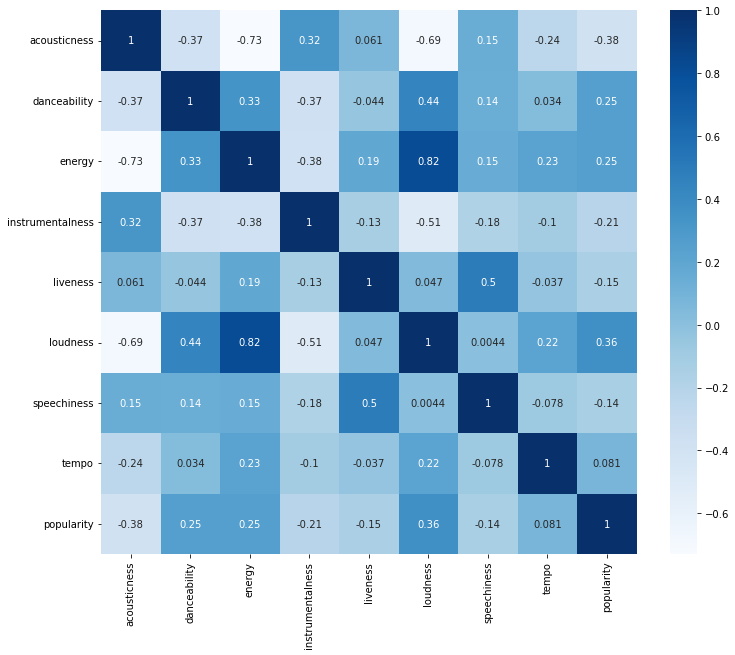

In [13]:
features = [
    "acousticness",
    "danceability",
    "energy",
    "instrumentalness",
    "liveness",
    "loudness",
    "speechiness",
    "tempo",
    "popularity",
]
cor = train_df[features].corr()
cor

import seaborn as sns
plt.figure(figsize=(12, 10))
sns.heatmap(cor, annot=True, cmap=plt.cm.Blues)
plt.show()

### Model Training (Ensembles)

In [15]:
# Since this is a Regression problem, making `mape_scorer` function

from sklearn.metrics import make_scorer


def mape(true, pred):
    return 100.0 * np.mean(np.abs((pred - true) / true))


# make a scorer function that we can pass into cross-validation
mape_scorer = make_scorer(mape, greater_is_better=False)

scoring_metrics = {
    "neg RMSE": "neg_root_mean_squared_error",
    "r2": "r2",
    "mape": mape_scorer,
}

In [16]:
results = {}

In [17]:
def mean_std_cross_val_scores(model, X_train, y_train, **kwargs):
    """
    Returns mean and std of cross validation

    Parameters
    ----------
    model :
        scikit-learn model
    X_train : numpy array or pandas DataFrame
        X in the training data
    y_train :
        y in the training data

    Returns
    ----------
        pandas Series with mean scores from cross_validation
    """

    scores = cross_validate(model, X_train, y_train, **kwargs)

    mean_scores = pd.DataFrame(scores).mean()
    std_scores = pd.DataFrame(scores).std()
    out_col = []

    for i in range(len(mean_scores)):
        out_col.append((f"%0.3f (+/- %0.3f)" % (mean_scores[i], std_scores[i])))

    return pd.Series(data=out_col, index=mean_scores.index)

#### Dummy Regressor

In [18]:
dummy_regressor_pipe = DummyRegressor()
results['Dummy Regressor'] = mean_std_cross_val_scores(dummy_regressor_pipe, X_train, y_train, scoring = scoring_metrics, return_train_score = True)
pd.DataFrame(results)

,Dummy Regressor
fit_time,0.011 (+/- 0.016)
score_time,0.002 (+/- 0.001)
test_neg RMSE,-18.103 (+/- 0.097)
train_neg RMSE,-18.100 (+/- 0.025)
test_r2,-0.001 (+/- 0.001)
train_r2,0.000 (+/- 0.000)
test_mape,-191.726 (+/- 10.022)
train_mape,-191.694 (+/- 1.963)


#### Decision Tree Regressor

In [20]:
decisiontree_regressor_pipe = make_pipeline(preprocessor_all, DecisionTreeRegressor())
results['Decision Tree Regressor'] = mean_std_cross_val_scores(decisiontree_regressor_pipe, X_train, y_train, return_train_score = True, scoring = scoring_metrics)
pd.DataFrame(results)

,Dummy Regressor,Decision Tree Regressor
fit_time,0.011 (+/- 0.016),1.444 (+/- 0.013)
score_time,0.002 (+/- 0.001),0.026 (+/- 0.000)
test_neg RMSE,-18.103 (+/- 0.097),-13.179 (+/- 0.127)
train_neg RMSE,-18.100 (+/- 0.025),-0.004 (+/- 0.002)
test_r2,-0.001 (+/- 0.001),0.470 (+/- 0.011)
train_r2,0.000 (+/- 0.000),1.000 (+/- 0.000)
test_mape,-191.726 (+/- 10.022),-64.358 (+/- 2.177)
train_mape,-191.694 (+/- 1.963),-0.000 (+/- 0.000)


#### Multiple Regressor models

In [21]:
from xgboost import XGBRegressor
from lightgbm.sklearn import LGBMRegressor
from catboost import CatBoostRegressor

pipe_ridge = make_pipeline(preprocessor_all, Ridge(random_state = 123))
pipe_random_forest = make_pipeline(preprocessor_all, RandomForestRegressor(random_state = 123))
pipe_xgboost = make_pipeline(preprocessor_all, XGBRegressor(random_state = 123,  eval_metric="logloss", verbosity=0))
pipe_lgbm = make_pipeline(preprocessor_all, LGBMRegressor(random_state = 123))
pipe_catboost = make_pipeline(preprocessor_all, CatBoostRegressor(random_state = 123, verbose=0))
models = {
    'Ridge' : pipe_ridge,
    'Random Forest' : pipe_random_forest,
    'XGBoost' : pipe_xgboost,
    'LGBM' : pipe_lgbm,
    'CatBoost' : pipe_catboost
}
   

In [27]:
for i in range(len(models)):
    models_pipeline = list(models.values())[i]
    models_pipeline.fit(X_train, y_train)
    results[list(models.keys())[i]] = mean_std_cross_val_scores(models_pipeline, X_train, y_train, cv=5, return_train_score = True, scoring = scoring_metrics)
pd.DataFrame(results)

,Dummy Regressor,Decision Tree Regressor,Ridge,Random Forest,XGBoost,LGBM,CatBoost,Voting Regressor,Stacking Regressor
fit_time,0.011 (+/- 0.016),1.444 (+/- 0.013),0.168 (+/- 0.008),178.760 (+/- 199.988),1.166 (+/- 0.055),0.340 (+/- 0.045),2.964 (+/- 0.020),94.806 (+/- 0.679),808.904 (+/- 835.823)
score_time,0.002 (+/- 0.001),0.026 (+/- 0.000),0.025 (+/- 0.001),0.129 (+/- 0.007),0.041 (+/- 0.003),0.037 (+/- 0.002),0.029 (+/- 0.001),0.255 (+/- 0.004),0.290 (+/- 0.014)
test_neg RMSE,-18.103 (+/- 0.097),-13.179 (+/- 0.127),-9.399 (+/- 0.101),-9.481 (+/- 0.077),-9.509 (+/- 0.093),-9.333 (+/- 0.065),-9.247 (+/- 0.075),-9.238 (+/- 0.073),-9.223 (+/- 0.076)
train_neg RMSE,-18.100 (+/- 0.025),-0.004 (+/- 0.002),-9.312 (+/- 0.026),-3.538 (+/- 0.014),-7.154 (+/- 0.052),-8.520 (+/- 0.020),-7.953 (+/- 0.027),-7.153 (+/- 0.017),-7.643 (+/- 0.126)
test_r2,-0.001 (+/- 0.001),0.470 (+/- 0.011),0.730 (+/- 0.008),0.725 (+/- 0.006),0.724 (+/- 0.007),0.734 (+/- 0.007),0.739 (+/- 0.007),0.739 (+/- 0.007),0.740 (+/- 0.007)
train_r2,0.000 (+/- 0.000),1.000 (+/- 0.000),0.735 (+/- 0.002),0.962 (+/- 0.000),0.844 (+/- 0.002),0.778 (+/- 0.001),0.807 (+/- 0.002),0.844 (+/- 0.001),0.822 (+/- 0.006)
test_mape,-191.726 (+/- 10.022),-64.358 (+/- 2.177),-59.595 (+/- 4.079),-57.114 (+/- 3.020),-57.066 (+/- 3.167),-58.061 (+/- 3.466),-56.469 (+/- 3.118),-57.011 (+/- 3.277),-55.817 (+/- 3.388)
train_mape,-191.694 (+/- 1.963),-0.000 (+/- 0.000),-58.811 (+/- 1.117),-21.017 (+/- 0.322),-37.773 (+/- 0.811),-51.580 (+/- 0.765),-45.384 (+/- 0.419),-42.447 (+/- 0.663),-44.226 (+/- 1.050)


**Analysis**

1) **Best Performing Model** - If we consider the R^2 metric to choose the best performing model, we can see that the train R^2 and the test R^2 of the Random forest model have a big gap and the train R^2 is pretty high. So, the Random Forest model seems to be overfitted compared to the other models. However, if we compare the R^2 score for Catboost model, we can see test R^2 is comparable to Random forest and the model does not seem to be overfitted. Even if we consider a different metric like MAPE, we see that CatBoost model seems to perform the best.

    **Worst Performing Model** - As we can see from the scores above, the worst performing model is Ridge with the worst test R^2 and test MAPE score compared to the other models.

2) **Overfitting/Underfitting** - Random forest and Xgboost seem to be the overfitted models as they have high train R^2 scores and the gap between the train and test R^2 are little big as well. Since both are tree based model and we haven't specified the hyperparameter for controlling the learning, the models seem to have overfitted.
It is very evident that the Ridge is underfitted and the model is not able to appropriately capture the trends of the data.

3) **Fit time** - Random forest takes the longest to fit as it has to fit default number of trees (100 according to scikit learn). Ridge takes the lowest time to fit the model.

4) **Score time** - Random forest is the slowest in scoring as it individually scores all the trees and cummulates the result. Ridge is the fastest model for scoring as it is a parametric model.

#### Voting Regressor

In [28]:
from sklearn.ensemble import VotingRegressor
averaging_model = VotingRegressor(
    list(models.items())
)

In [29]:
results['Voting Regressor'] = mean_std_cross_val_scores(averaging_model, X_train, y_train, return_train_score = True, scoring = scoring_metrics)
pd.DataFrame(results)

,Dummy Regressor,Decision Tree Regressor,Ridge,Random Forest,XGBoost,LGBM,CatBoost,Voting Regressor,Stacking Regressor
fit_time,0.011 (+/- 0.016),1.444 (+/- 0.013),0.168 (+/- 0.008),178.760 (+/- 199.988),1.166 (+/- 0.055),0.340 (+/- 0.045),2.964 (+/- 0.020),95.881 (+/- 1.007),808.904 (+/- 835.823)
score_time,0.002 (+/- 0.001),0.026 (+/- 0.000),0.025 (+/- 0.001),0.129 (+/- 0.007),0.041 (+/- 0.003),0.037 (+/- 0.002),0.029 (+/- 0.001),0.266 (+/- 0.019),0.290 (+/- 0.014)
test_neg RMSE,-18.103 (+/- 0.097),-13.179 (+/- 0.127),-9.399 (+/- 0.101),-9.481 (+/- 0.077),-9.509 (+/- 0.093),-9.333 (+/- 0.065),-9.247 (+/- 0.075),-9.238 (+/- 0.073),-9.223 (+/- 0.076)
train_neg RMSE,-18.100 (+/- 0.025),-0.004 (+/- 0.002),-9.312 (+/- 0.026),-3.538 (+/- 0.014),-7.154 (+/- 0.052),-8.520 (+/- 0.020),-7.953 (+/- 0.027),-7.153 (+/- 0.017),-7.643 (+/- 0.126)
test_r2,-0.001 (+/- 0.001),0.470 (+/- 0.011),0.730 (+/- 0.008),0.725 (+/- 0.006),0.724 (+/- 0.007),0.734 (+/- 0.007),0.739 (+/- 0.007),0.739 (+/- 0.007),0.740 (+/- 0.007)
train_r2,0.000 (+/- 0.000),1.000 (+/- 0.000),0.735 (+/- 0.002),0.962 (+/- 0.000),0.844 (+/- 0.002),0.778 (+/- 0.001),0.807 (+/- 0.002),0.844 (+/- 0.001),0.822 (+/- 0.006)
test_mape,-191.726 (+/- 10.022),-64.358 (+/- 2.177),-59.595 (+/- 4.079),-57.114 (+/- 3.020),-57.066 (+/- 3.167),-58.061 (+/- 3.466),-56.469 (+/- 3.118),-57.011 (+/- 3.277),-55.817 (+/- 3.388)
train_mape,-191.694 (+/- 1.963),-0.000 (+/- 0.000),-58.811 (+/- 1.117),-21.017 (+/- 0.322),-37.773 (+/- 0.811),-51.580 (+/- 0.765),-45.384 (+/- 0.419),-42.447 (+/- 0.663),-44.226 (+/- 1.050)


#### Stacking Regressor

In [30]:
from sklearn.ensemble import StackingRegressor
stacking_model = StackingRegressor(
    list(models.items()), final_estimator = Ridge())

stacking_model.fit(X_train, y_train)

StackingRegressor(estimators=[('Ridge',
                               Pipeline(steps=[('columntransformer',
                                                ColumnTransformer(transformers=[('standardscaler',
                                                                                 StandardScaler(),
                                                                                 ['instrumentalness',
                                                                                  'valence',
                                                                                  'duration_ms',
                                                                                  'loudness',
                                                                                  'liveness',
                                                                                  'speechiness',
                                                                                  'tempo',
                         

In [31]:
results['Stacking Regressor'] = mean_std_cross_val_scores(stacking_model, X_train, y_train, return_train_score = True, scoring = scoring_metrics)
pd.DataFrame(results)

,Dummy Regressor,Decision Tree Regressor,Ridge,Random Forest,XGBoost,LGBM,CatBoost,Voting Regressor,Stacking Regressor
fit_time,0.011 (+/- 0.016),1.444 (+/- 0.013),0.168 (+/- 0.008),178.760 (+/- 199.988),1.166 (+/- 0.055),0.340 (+/- 0.045),2.964 (+/- 0.020),95.881 (+/- 1.007),448.790 (+/- 19.540)
score_time,0.002 (+/- 0.001),0.026 (+/- 0.000),0.025 (+/- 0.001),0.129 (+/- 0.007),0.041 (+/- 0.003),0.037 (+/- 0.002),0.029 (+/- 0.001),0.266 (+/- 0.019),0.277 (+/- 0.014)
test_neg RMSE,-18.103 (+/- 0.097),-13.179 (+/- 0.127),-9.399 (+/- 0.101),-9.481 (+/- 0.077),-9.509 (+/- 0.093),-9.333 (+/- 0.065),-9.247 (+/- 0.075),-9.238 (+/- 0.073),-9.223 (+/- 0.076)
train_neg RMSE,-18.100 (+/- 0.025),-0.004 (+/- 0.002),-9.312 (+/- 0.026),-3.538 (+/- 0.014),-7.154 (+/- 0.052),-8.520 (+/- 0.020),-7.953 (+/- 0.027),-7.153 (+/- 0.017),-7.643 (+/- 0.126)
test_r2,-0.001 (+/- 0.001),0.470 (+/- 0.011),0.730 (+/- 0.008),0.725 (+/- 0.006),0.724 (+/- 0.007),0.734 (+/- 0.007),0.739 (+/- 0.007),0.739 (+/- 0.007),0.740 (+/- 0.007)
train_r2,0.000 (+/- 0.000),1.000 (+/- 0.000),0.735 (+/- 0.002),0.962 (+/- 0.000),0.844 (+/- 0.002),0.778 (+/- 0.001),0.807 (+/- 0.002),0.844 (+/- 0.001),0.822 (+/- 0.006)
test_mape,-191.726 (+/- 10.022),-64.358 (+/- 2.177),-59.595 (+/- 4.079),-57.114 (+/- 3.020),-57.066 (+/- 3.167),-58.061 (+/- 3.466),-56.469 (+/- 3.118),-57.011 (+/- 3.277),-55.817 (+/- 3.388)
train_mape,-191.694 (+/- 1.963),-0.000 (+/- 0.000),-58.811 (+/- 1.117),-21.017 (+/- 0.322),-37.773 (+/- 0.811),-51.580 (+/- 0.765),-45.384 (+/- 0.419),-42.447 (+/- 0.663),-44.226 (+/- 1.050)


**Analysis**

**fit_time** : The fit time for `StackingRegressor` is around 448 and is the highest compared to voting regressor and other model scores. This is because during the fit time, the individual models are fit and based on their results, coefficients are learned by the final estimator based on which it makes the final prediction during score time. Also, when we apply cross validation on the final estimator it also individually applies Cross validation on the individual models (loops within loops).

**score_time** : The score time of Stacking Regressor is pretty low as it already has the learned coefficients (learned during fit) and has the outputs from the individual models. It makes the final prediction based on these values.

**cross - validation scores** : The Cross Validation score for Stacking Regressor is 0.740 and is the highest compared to the validation scores of the other models.

In [32]:
# Analysis of the coefficients learnt by the Stacking Regressor

pd.DataFrame(
    data=stacking_model.final_estimator_.coef_.flatten(),
    index=models.keys(),
    columns=["Coefficient"],
).sort_values("Coefficient", ascending=False)

,Coefficient
CatBoost,0.560974
Ridge,0.166018
Random Forest,0.132564
LGBM,0.109328
XGBoost,0.042180


The `CatBoost` has the largest coefficient in magnitude (0.560974). It means that the CatBoost Regressor's predictions are trusted and weighted the most compared to the predictions generated by other Regressors. This means that the results of the individual CatBoost Regressor will largely affect the final predictions of the Stacking Regressor.

#### True Popularity VS Predicted Popularity

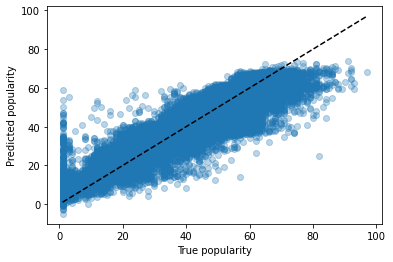

In [33]:
# We will use the Catboost Regressor because the catboost regressor is really close to the scores of our ensemble models
plt.scatter(y_train, pipe_catboost.predict(X_train), alpha=0.3)
grid = np.linspace(y_train.min(), y_train.max(), 1000)
plt.plot(grid, grid, "--k")
plt.xlabel("True popularity")
plt.ylabel("Predicted popularity");

In the above plot, we can see a few cases where our prediction is way off. We can see that few of the data points are under the line and hence we can see that the model is under estimating the predicted popularity for samples with high true popularity values. In the case of samples with low true popularity values, we can see that the model is over estimating the predicted popularity score.

#### Feature Importances (using SHAP)

We'll be using SHAP (SHapley Additive exPlanations) to explain predictions made by our lgbm model with all features.

In [37]:
# Fetching all the feature names

standard_scaler_names = pipe_lgbm.named_steps['columntransformer'].named_transformers_['standardscaler'].get_feature_names_out().tolist() 
ohe_1_names = pipe_lgbm.named_steps['columntransformer'].named_transformers_['onehotencoder-1'].get_feature_names_out().tolist()
ohe_2_names = pipe_lgbm.named_steps['columntransformer'].named_transformers_['onehotencoder-2'].get_feature_names_out().tolist()
count_vectorizer_names = pipe_lgbm.named_steps['columntransformer'].named_transformers_['countvectorizer'].get_feature_names_out().tolist()



feature_names = standard_scaler_names + ohe_1_names + ohe_2_names + count_vectorizer_names

In [38]:
import shap

In [39]:
preprocessor_all.fit(X_train, y_train)

ColumnTransformer(transformers=[('standardscaler', StandardScaler(),
                                 ['instrumentalness', 'valence', 'duration_ms',
                                  'loudness', 'liveness', 'speechiness',
                                  'tempo', 'acousticness', 'energy',
                                  'danceability']),
                                ('onehotencoder-1',
                                 OneHotEncoder(drop='if_binary', dtype='int'),
                                 ['mode']),
                                ('onehotencoder-2',
                                 OneHotEncoder(dtype='int',
                                               handle_unknown='ignore'),
                                 ['genre', 'time_signature', 'key']),
                                ('countvectorizer',
                                 CountVectorizer(max_features=100,
                                                 stop_words='english'),
                                 'tr

In [40]:
X_train_enc = pd.DataFrame(
    data=preprocessor_all.transform(X_train).toarray(),
    columns=feature_names,
    index=X_train.index,
)
X_train_enc.head()

,instrumentalness,valence,duration_ms,loudness,liveness,speechiness,tempo,acousticness,energy,danceability,...,te,theme,time,tu,version,want,way,woman,world,young
83705,-0.492597,-0.500406,0.134321,0.184088,-0.626636,0.644109,1.367649,-0.998580,-0.185516,0.365712,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
112786,-0.492597,0.367574,0.377767,0.462365,-0.507870,1.271303,-1.165830,-0.654586,0.143959,-0.506368,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
55692,-0.488900,-0.683943,0.398914,0.224791,-0.482600,-0.499696,1.542728,-0.828272,-0.276405,-1.014635,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
47357,-0.492592,1.747930,-0.614813,0.760079,-0.361307,-0.486492,0.154021,-0.156331,1.143744,0.488766,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
127661,2.137586,-1.599337,0.839209,-2.958692,0.260322,-0.441928,-1.011623,1.718459,-2.004821,-2.277279,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [41]:
X_test_enc = pd.DataFrame(
    data=preprocessor_all.transform(X_test).toarray(),
    columns=feature_names,
    index=X_test.index,
)
X_test_enc.head()

,instrumentalness,valence,duration_ms,loudness,liveness,speechiness,tempo,acousticness,energy,danceability,...,te,theme,time,tu,version,want,way,woman,world,young
116505,-0.492597,0.168742,-0.425952,0.567196,-0.781791,0.011413,1.170032,-0.705256,0.098514,1.168239,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
147921,0.940264,0.057854,-0.778585,0.321648,-0.512924,-0.194901,-0.686487,-1.008714,0.590832,0.017950,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
229940,-0.491105,1.006132,-0.321042,0.829690,0.219890,-0.468336,0.127825,-0.783232,0.730954,1.055885,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
107239,-0.492343,-1.119845,0.157837,-1.754876,-0.724176,-0.315389,0.701665,1.738164,-1.801077,-0.795278,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
102112,-0.492491,-0.645706,-0.159568,0.632819,-0.361307,-0.485391,0.189821,-0.330861,0.136385,-0.126505,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [42]:
lgbm_explainer = shap.TreeExplainer(pipe_lgbm.named_steps["lgbmregressor"])
train_lgbm_shap_values = lgbm_explainer.shap_values(X_train_enc)

In [43]:
test_lgbm_shap_values = lgbm_explainer.shap_values(X_test_enc[:100])

In [44]:
train_lgbm_shap_values.shape

(23272, 154)

In [45]:
# Summary Plots

shap.initjs()

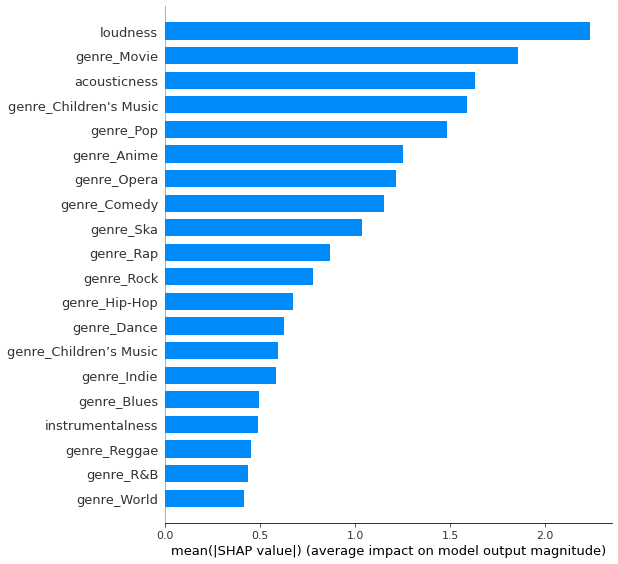

In [46]:
shap.summary_plot(train_lgbm_shap_values, X_train_enc, plot_type="bar")

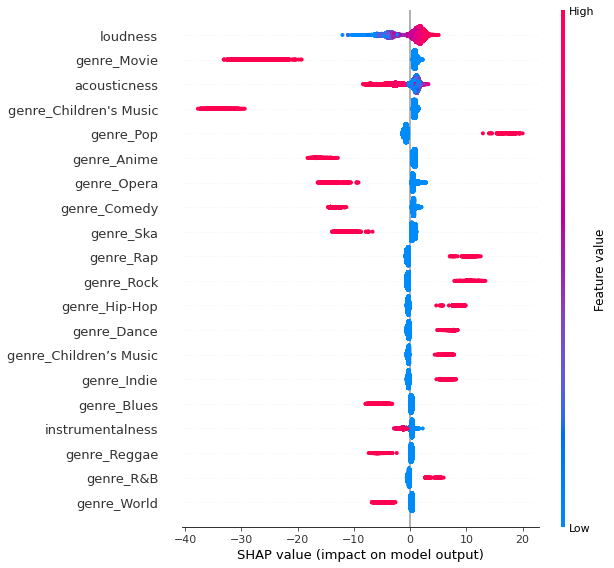

In [47]:
shap.summary_plot(train_lgbm_shap_values, X_train_enc)

**Analysis**

**Plot 1** 

The first plot shows the average SHAP value for each feature. Based on the 1st plot generated we can say that the feature `loudness` has highest average impact on the model's output (seems most important feature) and the feature `genreWorld` has the lowest average impact on the model's output.

**Plot 2**

The second plot above shows the most important features for predicting the output and It also shows the direction of how the features are going to drive the prediction. As we can see above, this plot shows the relationship between the value of a feature and the impact on the prediction. Based on the plot. Few of the features mentioned below seem to be important and have significant impact on the predictions :

In the case of `loudness`, we can see that high feature value would lead to a low SHAP close to zero (positive) value which means that bigger values for this feature are going to push the predictions to a smaller number and low feature value is going to give a negative SHAP value which means it will push the prediction to a really small number.

In the case of `genre_Pop`, we can see that high feature value lead to big SHAP values which means that presence of this feature are going to push the predictions to a bigger number and as low feature value would not have any impact on the predictions (very low impact).

Overall, `loudness` seems to be the most important feature.

#### Model Evaluation

In [49]:
stacking_model.score(X_test, y_test)

0.7380574404298833

In [50]:
pipe_catboost.score(X_test, y_test)

0.7370399279326817

**Analysis**

As we can see in our final model evaluation, the test score of our best performing models is pretty close to each other around 0.737. It does not make sense to use the Stacking Regressor over Catboost here as the computational resources used by the Stacking Regressor is a lot more compared to Catboost Regressor and the scores are pretty close. We can see that the scores are pretty close to what we got for our validation data which means the model generalizes well.